# **Lab 4: LLM Quantization with AWQ**
> MIT 6.5940 EfficientML.ai Fall 2023

이번 시간은 LLM Quantization을 실습하는 시간입니다. 데이터셋으로는 wikitext-2-raw-v1를 사용한고 Facebook에서 공개한 1.3 Billion 크기의 LLM 모델을 가지고 Activation Aware Quantization을 실습해볼 것입니다.

Top 1%를 FP16으로 유지하면 Weight가 다른 데이터 타입으로 해야하는 데 이는 현실적으로는 힘들다고 하기에, Scaling하는 것 까지 실험할 예정입니다.

실습 순서는 다음과 같습니다.

1. Setup (Package, Model, Dataset)
2. 4bit Quantization LLM
3. Keep Top 1% of the activations
4. Keep Random 1% of the activations
5. Scale Top 1% of the activations
6. Scale activation in serach space 

이번 실습은 길지 않아 순서대로 진행하며, 각 단계별로 실험 결과를 확인해보면 되겠습니다.

## Introduction

This colab notebook provides code and a framework for Lab 4: LLM Quantization. You will learn how to quantize a large language model that can run efficiently. We will implement AWQ (activation aware weight only quantization) for 4 bit weight-only quantization.

Running large language models (LLMs) on the edge is of great importance, which not only enhances user experience but also addresses privacy concerns, as sensitive data remains localized and reduces the risk of potential breaches.

However, deploying LLMs on the edge presents significant challenges. Edge devices operate under tight power constraints, setting them apart from workstations or cloud servers. This translates to restricted memory bandwidth and limited peak computation throughput on the edge. For instance, the NVIDIA Jetson Orin Nano, with its 8GB DRAM, cannot accommodate even the most compact LLaMA-2 model in half precision. Thankfully, AWQ presents a push-the-button solution for weight quantization, empowering LLM inference on edge devices with constrained memory.

Furthermore, by using the AWQ 4-bit weight-only quantization algorithm, combined with an efficient 4-bit kernel, we can achieve the following acceleration on the RTX 4090. In the next lab section, we will also use TinyChatEnigne to achieve actual performance acceleration.

# AWQ (activation aware weight only quantization)

![](../../images/lab04/1.png)

Large language models (LLMs) have shown excellent performance on various tasks, but the astronomical model size raises the hardware barrier for serving (memory size) and slows down token generation (memory bandwidth). LLM sizes and computation are increasing exponentially, while memory bandwidth is increasing slowly. This gap is a major bottleneck for LLMs. In this lab, we will explore the use of an novel quantization algorithm (AWQ) to reduce memory footprint of LLMs and achieve accelerations for inference.

In previous courses, we have learned the basic methods of quantization.
There are two types of quantization:

- Quantize both weight and activation
    - Better for computation-bounded scenarios: context stage, large batch inference
    - For example, SmoothQuant: W8A8 quantization
- Weight-only quantization
    - Better for memory-bounded scenarios: decoding stage, single batch inference
    - For example, AWQ that will be introduced in this lab: W4A16 quantization

For the LLaMA-65B model, in the decoding stage of single batch inference, we need to perform GEMV $[1, 8192] \times [8192, 8192]$. Taking the NVIDIA A100 80G as an example, its half-precision (FP16) performance is 312TFLOPS, and the memory bandwidth is about 2000GB/s. Therefore, its computation intensity is:

$$
\frac{\text{FLOP}}{\text{Byte}} = \frac{2\times 8192^2}{8192^2} << \frac{3.12\times 10^{11}}{2\times 10^9}
$$

This is very memory-bounded (~$10^2$ gap), which is why we need low-bit weight quantization.

## Setup

In [ ]:
print('Installing packages...')
!pip install torch transformers==4.31.0 accelerate==0.21.0 sentencepiece==0.1.99 tokenizers==0.13.3 tqdm zstandard
# !pip install torch transformers==4.31.0 accelerate==0.21.0 sentencepiece==0.1.99 tokenizers==0.13.3 datasets==2.14.4 tqdm zstandard

In [ ]:
# ValueError: Invalid pattern: '**' can only be an entire path component
# https://stackoverflow.com/questions/77671277/valueerror-invalid-pattern-can-only-be-an-entire-path-component
# The solution works for datasets version 2.10.1 on Python 3.10, as it should update the package with a hotfix that was added for version > 2.15.0.
!pip install -U datasets

In [22]:
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from functools import partial
import gc

Here we use wikitext-2 dataset for evaluation. The dataset is automatically downloaded by the code.

In [23]:
def evaluate(model, tokenizer):
    testenc = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
    # testenc = load_dataset('wikitext', 'wikitext-103-v1', split='train')
    testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')

    testenc = testenc.input_ids.to(model.device)
    nsamples = 40
    model = model.eval()

    nlls = []
    for i in tqdm.tqdm(range(nsamples), desc="evaluating..."):
        batch = testenc[:, (i * 2048):((i + 1) * 2048)].to(model.device)
        with torch.no_grad():
            lm_logits = model(batch).logits
        shift_logits = lm_logits[:, :-1, :].contiguous().float()
        shift_labels = testenc[:, (i * 2048):((i + 1) * 2048)][:, 1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        neg_log_likelihood = loss.float() * 2048
        nlls.append(neg_log_likelihood)

    return torch.exp(torch.stack(nlls).sum() / (nsamples * 2048))


The following code is used to calculate the model size.

In [24]:
def get_model_size(model: nn.Module, data_width=16, group_size=-1):

    if group_size != -1:
        data_width += (16 + 4) / group_size

    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [45]:
model_path = "facebook/opt-1.3b"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

Let's first evaluate the perplexity and model size of the FP32 Model.

In [26]:
# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=32, group_size=128)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s]


model perplexity: 14.47
model size: 5043.73 MiB


In [ ]:
# Check each layer in model 
for n, m in model.named_modules():
    print(f"{n}: {m}")
    if isinstance(m, nn.Linear):
        print(f"{n}: {m.weight.shape}")

Uniform quantization is to map real values in the range $[\beta, \alpha]$ to lie within $[0, 2^{b} - 1]$.

Notation:

- Quantized Weight: $w_q$

- Scale factor: $s_q$

- Zero Point: $z$

\begin{equation}
s_q = \frac{\alpha - \beta}{2^{b} - 1} \tag{1},
\end{equation}

\begin{equation}
z = -\text{Round}(\beta * scale) \tag{2}
\end{equation}

\begin{equation}
w_q = \text{Clamp}(\text{Round}(\frac{w}{s_q}) + z) \tag{3},
\end{equation}



### pseudo quantization
The following code is for pseudo quantization.

Pseudo Quantization is used to simulate the effects of quantization on a model  without actually quantizing the model's weights. (i.e. rounding to the nearest quantized value and then **dequantizing back to a float**.)

In [28]:
test_vector = torch.randn(10)
# test_vector[0] = torch.nan
torch.isnan(test_vector).sum() == 0

tensor(True)

In [29]:
# core quantization method (simulated quantization)
def pseudo_quantize_tensor(w, n_bit=4, q_group_size=-1):
    org_w_shape = w.shape
    if q_group_size > 0:
        assert org_w_shape[-1] % q_group_size == 0
        w = w.reshape(-1, q_group_size)

    assert w.dim() == 2

    # Calculate the maximum (\alpha) and minimum values (\beta) in the tensor.
    max_val = w.amax(dim=1, keepdim=True)
    assert max_val.dim() == 2 and max_val.size(0) == w.size(0) and max_val.size(1) == 1
    min_val = w.amin(dim=1, keepdim=True)
    assert min_val.dim() == 2 and min_val.size(0) == w.size(0) and min_val.size(1) == 1

    # Calculate the scale factor and zero point.  (Formula 1 & 2)
    max_int = 2 ** n_bit - 1
    scales = (max_val - min_val).clamp(min=1e-5) / max_int
    assert scales.shape == max_val.shape
    zeros = (-torch.round(min_val / scales)).clamp_(0, max_int)
    assert scales.shape == min_val.shape
    assert torch.isnan(scales).sum() == 0
    assert torch.isnan(w).sum() == 0

    # Quantize W: Map values in the range [\beta, \alpha] to lie within [0, 2^b - 1] (Formula 3)
    w = torch.clamp(torch.round(w / scales) + zeros, 0, max_int)
    assert w.dim() == 2 and w.size(0) == scales.size(0) and w.size(1) == q_group_size

    # Dequantize W (pseudo quantization, the inverse transformation of Formula 3)
    w = (w - zeros) * scales
    assert w.dim() == 2 and w.size(0) == scales.size(0) and w.size(1) == q_group_size

    assert torch.isnan(w).sum() == 0

    w = w.reshape(org_w_shape)
    return w

@torch.no_grad()
def pseudo_quantize_model_weight(
    model, w_bit, q_group_size,
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

Let's evaluate the perplexity and model size of the quantized 3-bit Model.

In [30]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_weight(model, w_bit=3, q_group_size=128)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]


model perplexity: 121.90
model size: 495.06 MiB


We can see that the model size has decreased, but the perplexity has significantly increased.

There is a observation in LLM activations that **outliers appear in a small fraction of the channels**. If one channel has an outlier, it **persistently appears in all tokens**. The variance amongst the channels for a given token is large (the activations in some channels are very large, but most are small), but the variance between the magnitudes of a given channel across tokens is small (outlier channels are consistently large).

According to the observation of AWQ, weight channels corresponding to activation outliers are more salient, and preserving those salient weights can lead to a significant performance improvement. Next, let's try to find the salient weights and retain them as original values to observe the change in perplexity.

The following code is used to load the calibration dataset, so as to obtain activation outliers to identify salient weights.

In [35]:
test_vector = torch.randn(10, 20, 10, 10)
print(test_vector.shape)
test_vector = test_vector.view(-1, test_vector.shape[-1])
print(test_vector.shape)
test_vector = test_vector.mean(dim=0)
print(test_vector.shape)

torch.Size([10, 20, 10, 10])
torch.Size([2000, 10])
torch.Size([10])


In [31]:
def get_calib_dataset(tokenizer=None, n_samples=256, block_size=512):
    dataset = load_dataset("mit-han-lab/pile-val-backup", split="validation")
    dataset = dataset.shuffle(seed=42)
    samples = []
    n_run = 0
    for data in dataset:
        line = data["text"]
        line = line.strip()
        line_encoded = tokenizer.encode(line)
        if len(line_encoded) > block_size:
            continue
        sample = torch.tensor([line_encoded])
        if sample.numel() == 0:
            continue
        samples.append(sample)
        n_run += 1
        if n_run == n_samples:
            break

    # now concatenate all samples and split according to block size
    cat_samples = torch.cat(samples, dim=1)
    n_split = cat_samples.shape[1] // block_size
    print(f" * Split into {n_split} blocks")
    return [cat_samples[:, i*block_size:(i+1)*block_size] for i in range(n_split)]

@torch.no_grad()
def get_calib_feat(model, tokenizer):
    input_dict = dict()
    def stat_input_max_hook(m, x, y, name):
        if isinstance(x, tuple):
            x = x[0]
        x_max = x.view(-1, x.shape[-1]).abs().mean(dim=0).cpu().detach()  # each channel's mean in each block (127 in this case)
        if name not in input_dict:
            input_dict[name] = [x_max]
        else:
            input_dict[name] += [x_max]

    hooks = []
    for name, m in model.named_modules():
        if isinstance(m, nn.Linear):
            hooks.append(
                m.register_forward_hook(
                    partial(stat_input_max_hook, name=name)))

    print("Collecting activation scales...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    samples = get_calib_dataset(tokenizer)
    pbar = tqdm.tqdm(samples)
    for input_ids in pbar:
        input_ids = input_ids.to(device)  # (1, 512)
        model(input_ids) # gather input max

    for hook in hooks:
        hook.remove()
    return input_dict

In [ ]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
input_feat = get_calib_feat(model, tokenizer) # each block's mean, 127 blocks

In [36]:
input_feat.__len__()

145

In [17]:
for k, v in input_feat.items():  # Max in each block(127 blocks)
    print(f"{k}: {v.__len__()} {v[0].shape}") # each kayer, 127 blocks, each block has 2048 elements
    break

model.decoder.layers.0.self_attn.q_proj: 127 torch.Size([2048])


### Question 1 (50 pts)
#### Question 1.1 (20 pts)
Next, please add codes before and after the quantization to protect 1% of the salient weight channels (1% channels with highest importance), ensuring that their values remain unchanged after quantization. (**The desired perplexity is 17.15**)

In [43]:
@torch.no_grad()
def pseudo_quantize_model_salient_weight_fp16(
    model, w_bit, q_group_size, input_feat
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance = sum(input_feat[n]).float()

            ############### YOUR CODE STARTS HERE ###############

            # Step 1: Find 1% of the salient weight channels according to importance (hint: use torch.topk())
            outlier_indices = torch.topk(importance, int(0.01 * importance.size(0)), largest=True).indices
            assert outlier_indices.dim() == 1

            ############### YOUR CODE ENDS HERE #################

            # Back up the values of the salient weight channels
            outlier = m.weight.data[:, outlier_indices].clone()

            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

            ############### YOUR CODE STARTS HERE ###############

            # Step 2: Restore the 1% salient weight channels to their original FP16 values
            m.weight.data[:, outlier_indices] = outlier

            ############### YOUR CODE ENDS HERE #################

In [46]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_salient_weight_fp16(model, w_bit=3, q_group_size=128, input_feat=input_feat)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]


model perplexity: 17.15
model size: 495.06 MiB


#### Question 1.2 (15 pts)
Let's conduct an ablation experiment: randomly protect 1% of the weight channels, ensuring that their values remain unchanged after quantization, and then observe the perplexity. (**The desired perplexity is over 100**)




In [47]:
x = torch.randn(20, )
print(x)
y = torch.randperm(x.size(0)) < 5
print(y)

tensor([ 0.5130,  3.1619, -1.9837, -1.1557, -0.4532, -0.4831,  0.7884, -0.1122,
         0.6722, -0.2606, -1.2696,  0.3370,  0.0889,  0.2339,  0.5943,  1.2150,
        -0.7380,  1.0870, -1.5264, -0.7932])
tensor([False, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False,  True, False, False,  True, False,  True])


In [48]:
@torch.no_grad()
def pseudo_quantize_model_random_weight_fp16(
    model, w_bit, q_group_size, input_feat
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance = sum(input_feat[n]).float()

            ############### YOUR CODE STARTS HERE ###############

            # Step 1: Randomly choose 1% of the weight channels
            outlier_mask = torch.randperm(importance.size(0)) < int(0.01 * importance.size(0))
            assert outlier_mask.dim() == 1

            ############### YOUR CODE ENDS HERE #################

            # Back up the values of the selected weight channels
            outlier = m.weight.data[:, outlier_mask].clone()

            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

            ############### YOUR CODE STARTS HERE ###############

            # Step 2: Restore the 1% selected weight channels to their original FP16 values
            m.weight.data[:, outlier_mask] = outlier  

            ############### YOUR CODE ENDS HERE #################

In [22]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_random_weight_fp16(model, w_bit=3, q_group_size=128, input_feat=input_feat)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s]


model perplexity: 116.94
model size: 495.06 MiB


#### Question 1.3 (15 pts)
Please provide a possible explanation for why the salient weight channels are so important.

#### Answser 1.3

When the salient weight channels remains not randomly, the model perlexity contains as high performance. It seems that the salient weight channels are important for the model to maintain its performance, and those channels have most information than other less important channels.


### Question 2 (50 pts)

Despite keeping 0.1% of weights in FP16 can improve the quantized performance
without a noticeable increase in model size (measured in total bits), such a mixed-precision data type will make the system implementation difficult. We need to come up with a method to protect the important weights without actually keeping them as FP16.

According to the methodology of AWQ, simply scaling up the salient weight channels can protect them. The principle is as follows:

- Consider a linear layer channel $\mathbf{y} = \mathbf{w}x$ (from $\mathbf{W}x$). We care about the quantization error from $Q(\mathbf{w})x$.

- $Err(Q(\mathbf{w}) x) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x$, $Δ = \frac{\max(|w|)}{2^{N - 1}}$.
- The scaled version is $Err(Q(\mathbf{w} \cdot s)(\frac{x}{s})) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x\cdot \mathbf{\frac{1}{s}}$.
- The $RoundErr$ is always ~0.25 (average from 0-0.5).
- When the group size is relatively large (e.g., 128), scaling up one channel usually does not increase the maximum value in a group (i.e. $Δ$ remains unchanged).
- Thus, $Err(Q(\mathbf{w} \cdot s)(\frac{x}{s})) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x\cdot \mathbf{\frac{1}{s}}$ < $Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x = Err(Q(\mathbf{w}) x)$.

Taking the following figure as an example, if we assume 3-bit int quantization, then the quantization error caused by the value in the last column of the second row of $W(+1.4)$ should be $Err(Q(\mathbf{w}) x) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x$ = $\frac{4}{2^{3 - 1}} * |1.4 - 1.0| * (2 + 2 + 2) = 2.4$.

If the second channel is scaled up by a factor of $2$, the resulting quantization error would reduce to $\frac{4}{2^{3 - 1}} * |2.8 - 3.0| * (2/2 + 2/2 + 2/2) = 0.6$.

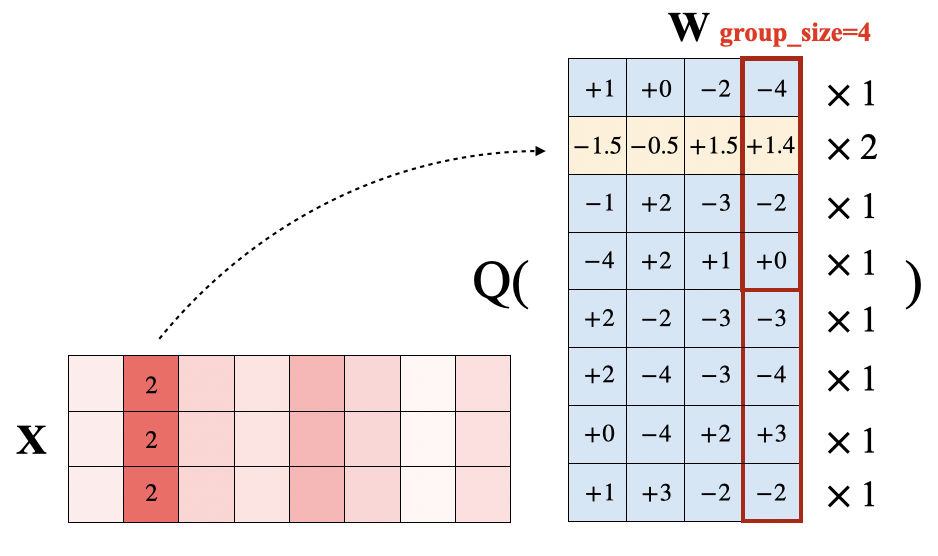

#### Question 2.1 (20 pts)
Please write code to scale up the salient weight channels, then quantize it, and finally scale it back down, and observe the changes in perplexity. (**The desired perplexity is 18.93**)

In [23]:
@torch.no_grad()
def pseudo_quantize_model_weight_scaleup(
    model, w_bit, q_group_size, input_feat, scale_factor
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance = sum(input_feat[n]).float()

            ############### YOUR CODE STARTS HERE ###############

            # Step 1: Find 1% of the salient weight channels
            outlier_mask = torch.topk(importance, int(0.01 * importance.size(0)), largest=True).indices
            assert outlier_mask.dim() == 1

            ############### YOUR CODE ENDS HERE #################

            # To simulate applying the scale factor, we can simply multiply it before quantization, and then divide by the scale factor after quantization.
            # Scale up the values of the salient weight channels
            m.weight.data[:, outlier_mask] *= scale_factor

            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

            ############### YOUR CODE STARTS HERE ###############

            # Step 2: Scale back down the values of the salient weight channels
            m.weight.data[:, outlier_mask] /= scale_factor

            ############### YOUR CODE ENDS HERE #################

In [24]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_weight_scaleup(model, w_bit=3, q_group_size=128, input_feat=input_feat, scale_factor=2)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]


model perplexity: 18.93
model size: 495.06 MiB


In [26]:
scale_list = (1, 2, 3, 4, 5, 6, 7, 8)
for scale_factor in scale_list:
    del model
    gc.collect()
    torch.cuda.empty_cache()
    model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
    pseudo_quantize_model_weight_scaleup(model, w_bit=3, q_group_size=128, input_feat=input_feat, scale_factor=scale_factor)

    # Evaluate the model
    model_perplexity = evaluate(model, tokenizer)
    model_size = get_model_size(model, data_width=3, group_size=128)
    print(f"\n  Scale factor {scale_factor}")
    print(f"\nmodel perplexity: {model_perplexity:.2f}")
    print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]



  Scale factor 1

model perplexity: 121.90
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]



  Scale factor 2

model perplexity: 18.93
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 3

model perplexity: 19.25
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 4

model perplexity: 21.26
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 5

model perplexity: 24.50
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 6

model perplexity: 30.36
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 7

model perplexity: 47.13
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]


  Scale factor 8

model perplexity: 100.99
model size: 495.06 MiB


In [30]:
scale_list = torch.arange(2, 3.1, 0.1)
for scale_factor in scale_list:
    del model
    gc.collect()
    torch.cuda.empty_cache()
    model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
    pseudo_quantize_model_weight_scaleup(model, w_bit=3, q_group_size=128, input_feat=input_feat, scale_factor=scale_factor)

    # Evaluate the model
    model_perplexity = evaluate(model, tokenizer)
    model_size = get_model_size(model, data_width=3, group_size=128)
    print(f"\n  Scale factor {scale_factor}")
    print(f"\nmodel perplexity: {model_perplexity:.2f}")
    print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]



  Scale factor 2.0

model perplexity: 18.93
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 2.0999999046325684

model perplexity: 18.86
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 2.200000047683716

model perplexity: 19.00
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 2.299999952316284

model perplexity: 18.96
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 2.4000000953674316

model perplexity: 18.97
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 2.5

model perplexity: 19.20
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 2.5999999046325684

model perplexity: 18.91
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 2.700000047683716

model perplexity: 19.03
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 2.799999952316284

model perplexity: 18.90
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 2.9000000953674316

model perplexity: 19.12
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]


  Scale factor 3.0

model perplexity: 19.25
model size: 495.06 MiB


In [31]:
scale_list = torch.arange(1, 2.1, 0.1)
for scale_factor in scale_list:
    del model
    gc.collect()
    torch.cuda.empty_cache()
    model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
    pseudo_quantize_model_weight_scaleup(model, w_bit=3, q_group_size=128, input_feat=input_feat, scale_factor=scale_factor)

    # Evaluate the model
    model_perplexity = evaluate(model, tokenizer)
    model_size = get_model_size(model, data_width=3, group_size=128)
    print(f"\n  Scale factor {scale_factor}")
    print(f"\nmodel perplexity: {model_perplexity:.2f}")
    print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]



  Scale factor 1.0

model perplexity: 121.90
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 1.100000023841858

model perplexity: 47.12
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 1.2000000476837158

model perplexity: 30.96
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 1.2999999523162842

model perplexity: 25.90
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 1.399999976158142

model perplexity: 21.14
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 1.5

model perplexity: 20.19
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 1.600000023841858

model perplexity: 19.71
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 1.7000000476837158

model perplexity: 19.01
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 1.7999999523162842

model perplexity: 18.97
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]



  Scale factor 1.899999976158142

model perplexity: 18.89
model size: 495.06 MiB


evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]


  Scale factor 2.0

model perplexity: 18.93
model size: 495.06 MiB


#### Question 2.2 (15 pts)
Please try different scale factors (e.g. 1, 2, 3, and 4) in the code and observe the changes in perplexity.

Did you observe the perplexity first decreasing and then increasing? Please explain why this would happen based on the principle mentioned above.

#### Answer 2.2
############### YOUR ANSWER STARTS HERE #################

From Scale 2, this perplexities are gradually increasing. At Scale 8, it reach out over the perplexity 100.

From Scale 2 to 3, those perplexities are also gradually increasing.

From Scale 1 to 2, those perplexities are also gradually decreasing and it reach out saturation at Scale 1.8

############### YOUR ANSWER ENDS HERE #################

### Question 2.3 (15 pts)
Due to the instability of fine-tuning, it would be a better choice to find the optimal $s$ within a predefined search space. We can find the optimal scale in the search space to protect the salient weights while also considering other values. In practice, it can be observed that considering just the activations is sufficient to yield good results. Please add the code for search and run it to observe the perplexity. (**The desired perplexity is 17.92**)

$$
𝐋(\mathbf{s})=\lVert Q(\mathbf{W}\cdot \mathbf{s})  (\mathbf{s^{-1}} \cdot \mathbf{X}) - \mathbf{W}\mathbf{X}  \rVert,  \quad\mathbf{s}= \mathbf{s_X}^{\alpha}
$$
$$
\mathbf{s}^* = \text{argmin}_{\mathbf{s}} 𝐋(\mathbf{s}),\quad \alpha^*=\text{argmin}_{\alpha} 𝐋(\mathbf{s_X}^{\alpha})
$$

In [49]:
@torch.no_grad()
def scale_ln_fcs(ln, fcs, scales):
    if not isinstance(fcs, list):
        fcs = [fcs]

    scales = scales.to(ln.weight.device)

    ln.weight.div_(scales)
    if hasattr(ln, 'bias') and ln.bias is not None:
        ln.bias.div_(scales)

    for fc in fcs:
        fc.weight.mul_(scales.view(1, -1))

    for p in ln.parameters():
        assert torch.isnan(p).sum() == 0
    for fc in fcs:
        for p in fc.parameters():
            assert torch.isnan(p).sum() == 0


@torch.no_grad()
def scale_fc_fc(fc1, fc2, scales):
    assert isinstance(fc1, nn.Linear)
    assert isinstance(fc2, nn.Linear)

    scales = scales.to(fc1.weight.device)

    # fc1.weight.div_(scales.view(-1, 1))
    fc1.weight[-scales.size(0):].div_(scales.view(-1, 1))
    if fc1.bias is not None:
        fc1.bias.div_(scales.view(-1))

    fc2.weight.mul_(scales.view(1, -1))

    for p in fc1.parameters():
        assert torch.isnan(p).sum() == 0
    for p in fc2.parameters():
        assert torch.isnan(p).sum() == 0

@torch.no_grad()
def auto_scale_block(module, name, w_bit,
                     q_group_size,
                     input_feat):

    # find the best scale ratio
    def _search_module_scale(block, linears2scale: list, x, kwargs={}):

        x = x.to(next(block.parameters()).device)
        with torch.no_grad():
            org_out = block(x, **kwargs)
            if isinstance(org_out, tuple):
                org_out = org_out[0]

        s_x = x.view(-1, x.shape[-1]).abs().mean(0)

        ############### YOUR CODE STARTS HERE ###############

        # Step 1: Initialize the best_error, best_ratio and best_scales
        best_error = float('inf')
        best_ratio = -1
        best_scales = None

        ############### YOUR CODE ENDS HERE #################

        n_grid = 20
        history = []

        org_sd = {k: v.cpu() for k, v in block.state_dict().items()}
        for ratio in range(n_grid):
            # ratio is the \alpha in the formula
            ratio = ratio * 1 / n_grid

            ############### YOUR CODE STARTS HERE ###############

            # Step 2: Calculate the scales by the formula: scales = s_x^ratio
            scales = torch.clamp(s_x, 1e-5).pow(ratio)
            assert scales.shape == s_x.shape

            ############### YOUR CODE ENDS HERE #################

            scales = scales / (scales.max() * scales.min()).sqrt().view(1, -1)

            for fc in linears2scale:

                scales = scales.to(fc.weight.device)

                # Scale up the values of the weight channels
                fc.weight.mul_(scales)

                fc.weight.data = pseudo_quantize_tensor(fc.weight.data, w_bit, q_group_size)

                ############### YOUR CODE STARTS HERE ###############

                # Step 3: Scale back down the values of the weight channels
                fc.weight.div_(scales)

                ############### YOUR CODE ENDS HERE #################

            out = block(x, **kwargs)
            if isinstance(out, tuple):
                out = out[0]

            loss = (org_out - out).float().pow(2).mean().item()  # float prevents overflow
            history.append(loss)
            is_best = loss < best_error
            if is_best:
                best_error = loss
                best_ratio = ratio
                best_scales = scales
            block.load_state_dict(org_sd)

        if best_ratio == -1:
            print(history)
            raise Exception

        best_scales = best_scales.view(-1)

        assert torch.isnan(best_scales).sum() == 0, best_scales
        return best_scales.detach()

    # attention input
    inp = input_feat[name + '.self_attn.out_proj']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0).unsqueeze(0)
    qkv = [module.self_attn.q_proj, module.self_attn.k_proj, module.self_attn.v_proj]
    final_scales = _search_module_scale(module.self_attn, qkv, inp)
    scale_ln_fcs(module.self_attn_layer_norm, qkv, final_scales)

    # attn out
    inp = input_feat[name + '.self_attn.out_proj']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.self_attn.out_proj, [module.self_attn.out_proj], inp)
    scale_fc_fc(module.self_attn.v_proj, module.self_attn.out_proj, final_scales)

    # fc1
    inp = input_feat[name + '.fc1']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.fc1, [module.fc1], inp)
    scale_ln_fcs(module.final_layer_norm, module.fc1, final_scales)

    # fc2
    inp = input_feat[name + '.fc2']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.fc2, [module.fc2], inp)
    scale_fc_fc(module.fc1, module.fc2, final_scales)

@torch.no_grad()
def pseudo_quantize_model_weight_auto_scale(
    model, w_bit, q_group_size, input_feat
):
    from transformers.models.opt.modeling_opt import OPTDecoderLayer

    for name, module in model.named_modules():
        if isinstance(module, OPTDecoderLayer):
            auto_scale_block(module, name, w_bit, q_group_size, input_feat)

    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

In [50]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_weight_auto_scale(model, w_bit=3, q_group_size=128, input_feat=input_feat)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]


model perplexity: 17.93
model size: 495.06 MiB


## Bonus point
Any optimization techniques without mixed precision on your mind? Try to implement them to improve the perplexity further! If you can further improve the perplexity to $x$, you can get $\max(0, (17.92 - x) \times 10)$ bonus points here!


In conclusion, we can significantly reduce perplexity without using mixed-precision. Through an efficient kernel implementation, the 4-bit model can achieve decent acceleration for inference. Through learning about TinyChatEngine in the next section, we can run a LLaMA-7B model on our own laptops like the demo presented in the introduction.